In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seed = 42
np.random.seed = seed
  
img_width = 128
img_height = 128
img_channels = 3

In [3]:
#data path
train_path = "stage1_train/"
test_path = "stage1_test/"

In [4]:
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

In [5]:
#number of files in train and test
print(len(next(os.walk(train_path))[1]))
print(len(next(os.walk(test_path))[1]))

670
65


In [6]:
random.shuffle(train_ids)

In [7]:
# create training data
x_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype = np.uint8)
y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype = np.bool)


In [8]:
x_train[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [9]:
print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = train_path + id_
    img = imread(path + "/images/" + id_ + '.png')[:, :, :img_channels]
    img = resize(img, (img_height, img_width), mode = "constant", preserve_range = True)
    x_train[n] = img
    mask = np.zeros((img_height, img_width,1), dtype = np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width),mode = 'constant',preserve_range = True), axis=-1)
        mask = np.maximum(mask, mask_)
        
    y_train[n] = mask

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [06:37<00:00,  1.69it/s]


In [10]:
# Test images

x_test = np.zeros((len(test_ids),img_height, img_width, img_channels), dtype = np.uint8)
sizes_test = []
print("Resizing test images")
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = test_path + id_
    img = imread(path + "/images/" + id_ + '.png')[:, :, :img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (img_height, img_width), mode = "constant", preserve_range = True)
    x_test[n] = img

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 41.69it/s]


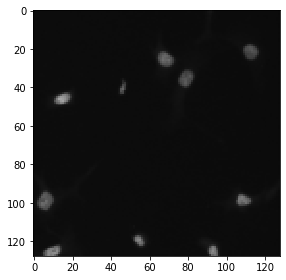

In [11]:
#visualize
imshow(x_train[9])
plt.show()

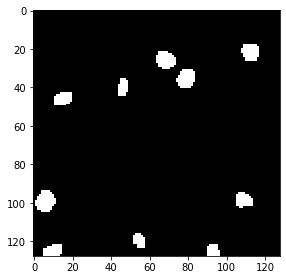

In [12]:
imshow(y_train[9])
plt.show()

In [13]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(670, 128, 128, 3)
(65, 128, 128, 3)
(670, 128, 128, 1)


In [14]:
#Build the model
inputs = tf.keras.layers.Input((img_height, img_width, img_channels))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [15]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("model_for_nuclei.h5", save_best_only = True,save_weights_only=True)

In [16]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2 , monitor = "val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer]

In [18]:
history = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)

Epoch 1/100
38/38 [==============================] - 24s 158ms/step - loss: 0.5136 - accuracy: 0.7742 - val_loss: 0.3150 - val_accuracy: 0.8176
Epoch 2/100
38/38 [==============================] - 3s 82ms/step - loss: 0.2536 - accuracy: 0.8597 - val_loss: 0.2013 - val_accuracy: 0.9339
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.93 - 3s 82ms/step - loss: 0.1731 - accuracy: 0.9381 - val_loss: 0.1367 - val_accuracy: 0.9494
Epoch 4/100
38/38 [==============================] - 3s 82ms/step - loss: 0.1331 - accuracy: 0.9500 - val_loss: 0.1258 - val_accuracy: 0.9533
Epoch 5/100
38/38 [==============================] - 3s 82ms/step - loss: 0.1237 - accuracy: 0.9529 - val_loss: 0.1182 - val_accuracy: 0.9553
Epoch 6/100
38/38 [==============================] - 3s 83ms/step - loss: 0.1179 - accuracy: 0.9554 - val_loss: 0.1127 - val_accuracy: 0.9571
Epoch 7/100
38/38 [==============================] - 3s 83ms/step - loss: 0.1066 - accuracy: 0.9601 - va

In [19]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

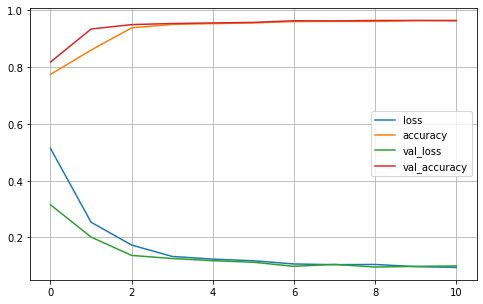

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [21]:
idx = random.randint(0, len(x_train))

In [22]:
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(x_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 196ms/step


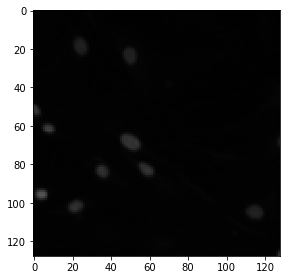

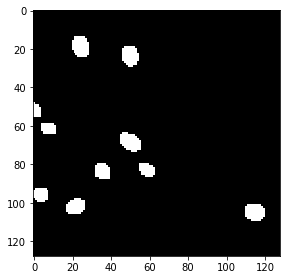

c:\users\vaibh\miniconda3\envs\cv\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


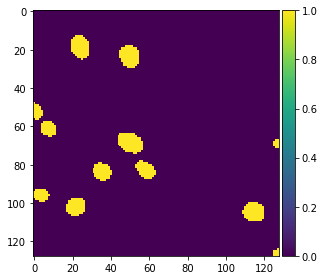

In [23]:
#perform a sanity check on some random training samples

ix = random.randint(0, len(preds_train_t))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

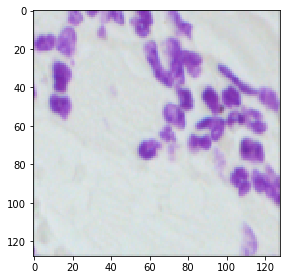

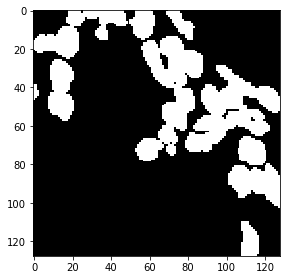

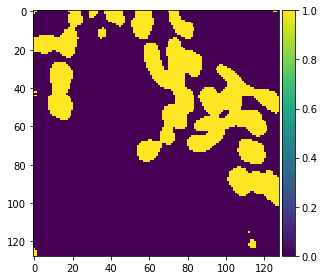

In [24]:
#perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(x_train[int(x_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()